In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import yaml

with open('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from category_encoders import wrapper
# from xgboost import XGBRegressor

In [4]:
df = pd.read_csv(cfg['datasets']['music'])
df.head()

/tmp/ipykernel_99137/1160318346.py:1: DtypeWarning: Columns (2,4,9,12,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cfg['datasets']['music'])


,Unnamed: 0,uri,rank,artist_names,artists_num,artist_individual,artist_id,artist_genre,artist_img,collab,...,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot
0,0,spotify:track:2gpQi3hbcUAcEG8m2dlgfB,1,Paulo Londra,1.0,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a9...,0,...,0.0495,0.0,0.0658,0.557,173.935,178203.0,Argentina,South America,Spanish,0
1,1,spotify:track:2x8oBuYaObjqHqgGuIUZ0b,2,WOS,1.0,WOS,spotify:artist:5YCc6xS5Gpj3EkaYGdjyNK,argentine indie,https://i.scdn.co/image/ab6761610000e5eb75e151...,0,...,0.724,0.0,0.134,0.262,81.956,183547.0,Argentina,South America,Spanish,0
2,2,spotify:track:2SJZdZ5DLtlRosJ2xHJJJa,3,Paulo Londra,1.0,Paulo Londra,spotify:artist:3vQ0GE3mI0dAaxIMYe5g7z,argentine hip hop,https://i.scdn.co/image/ab6761610000e5ebf796a9...,0,...,0.241,0.0,0.0929,0.216,137.915,204003.0,Argentina,South America,Spanish,0
3,3,spotify:track:1O2pcBJGej0pmH2Y9XZMs6,5,Cris Mj,1.0,Cris Mj,spotify:artist:1Yj5Xey7kTwvZla8sqdsdE,urbano chileno,https://i.scdn.co/image/ab6761610000e5eb8f4ebc...,0,...,0.0924,0.000046,0.0534,0.832,96.018,153750.0,Argentina,South America,Spanish,0
4,4,spotify:track:1TpZKxGnHp37ohJRszTSiq,6,Emilia,1.0,Emilia,spotify:artist:0AqlFI0tz2DsEoJlKSIiT9,pop argentino,https://i.scdn.co/image/ab6761610000e5ebaf96d1...,0,...,0.0811,0.000063,0.101,0.501,95.066,133895.0,Argentina,South America,Spanish,0


In [5]:
df.drop(
    ['Unnamed: 0', 'uri','artist_names','artist_individual','artist_id', 'artist_img', 'track_name', 'release_date', 'album_cover', 'source', 'week', ],
    axis=1,
    inplace=True
)
df

,rank,artists_num,artist_genre,collab,album_num_tracks,peak_rank,previous_rank,weeks_on_chart,streams,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration,country,region,language,pivot
0,1,1.0,argentine hip hop,0,1.0,1,1,4,3003411,0.583,...,0.0495,0.0,0.0658,0.557,173.935,178203.0,Argentina,South America,Spanish,0
1,2,1.0,argentine indie,0,1.0,2,129,2,2512175,0.654,...,0.724,0.0,0.134,0.262,81.956,183547.0,Argentina,South America,Spanish,0
2,3,1.0,argentine hip hop,0,2.0,3,59,2,2408983,0.721,...,0.241,0.0,0.0929,0.216,137.915,204003.0,Argentina,South America,Spanish,0
3,5,1.0,urbano chileno,0,1.0,5,5,8,2080139,0.87,...,0.0924,0.000046,0.0534,0.832,96.018,153750.0,Argentina,South America,Spanish,0
4,6,1.0,pop argentino,0,1.0,6,9,3,1923270,0.761,...,0.0811,0.000063,0.101,0.501,95.066,133895.0,Argentina,South America,Spanish,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787994,197,2.0,pop,1,33.0,197,-1,1,37591,0.743,...,0.0188,0.0,0.287,0.545,110.015,231173,Vietnam,Asia,Vietnamese,0
1787995,197,2.0,hip hop,1,33.0,197,-1,1,37591,0.743,...,0.0188,0.0,0.287,0.545,110.015,231173,Vietnam,Asia,Vietnamese,1
1787996,199,3.0,mellow gold,1,17.0,114,183,30,36817,0.795,...,0.0354,0.000073,0.0915,0.934,116.032,202735,Vietnam,Asia,Vietnamese,0
1787997,199,3.0,pop,1,17.0,114,183,30,36817,0.795,...,0.0354,0.000073,0.0915,0.934,116.032,202735,Vietnam,Asia,Vietnamese,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787999 entries, 0 to 1787998
Data columns (total 25 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   rank              object
 1   artists_num       object
 2   artist_genre      object
 3   collab            object
 4   album_num_tracks  object
 5   peak_rank         object
 6   previous_rank     object
 7   weeks_on_chart    object
 8   streams           object
 9   danceability      object
 10  energy            object
 11  key               object
 12  mode              object
 13  loudness          object
 14  speechiness       object
 15  acousticness      object
 16  instrumentalness  object
 17  liveness          object
 18  valence           object
 19  tempo             object
 20  duration          object
 21  country           object
 22  region            object
 23  language          object
 24  pivot             object
dtypes: object(25)
memory usage: 341.0+ MB


In [7]:
df['collab'].unique()

array([0, 1, '1', 'collab', '0'], dtype=object)

In [8]:
df['collab'].value_counts()

1         614704
0         515719
1         507626
0         149877
collab        73
Name: collab, dtype: int64

In [9]:
df.shape

(1787999, 25)

In [10]:
df.set_index('collab', inplace = True)
df = df.drop('collab')
df.reset_index(inplace= True)

In [11]:
df.shape

(1787926, 25)

In [12]:
columns_to_numeric = list(df.columns)
columns_not_to_numeric = ['artist_genre', 'country', 'region', 'language']
for column in columns_not_to_numeric:
    if column in columns_to_numeric:
        columns_to_numeric.remove(column)
columns_to_numeric
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')
#in this usage we can get different numeric types
#df.loc[:, columns_to_numeric] = pd.to_numeric(df[columns_to_numeric].values.ravel(), 'coerce').reshape(-1, len(columns_to_numeric))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787926 entries, 0 to 1787925
Data columns (total 25 columns):
 #   Column            Dtype  
---  ------            -----  
 0   collab            int64  
 1   rank              int64  
 2   artists_num       float64
 3   artist_genre      object 
 4   album_num_tracks  float64
 5   peak_rank         int64  
 6   previous_rank     int64  
 7   weeks_on_chart    int64  
 8   streams           int64  
 9   danceability      float64
 10  energy            float64
 11  key               float64
 12  mode              float64
 13  loudness          float64
 14  speechiness       float64
 15  acousticness      float64
 16  instrumentalness  float64
 17  liveness          float64
 18  valence           float64
 19  tempo             float64
 20  duration          float64
 21  country           object 
 22  region            object 
 23  language          object 
 24  pivot             int64  
dtypes: float64(14), int64(7), object(4)
memory us

In [14]:
df['collab'].unique()

array([0, 1])

In [15]:
cat_df = df.select_dtypes(include=['object'])
num_df = df.select_dtypes(exclude=['object'])

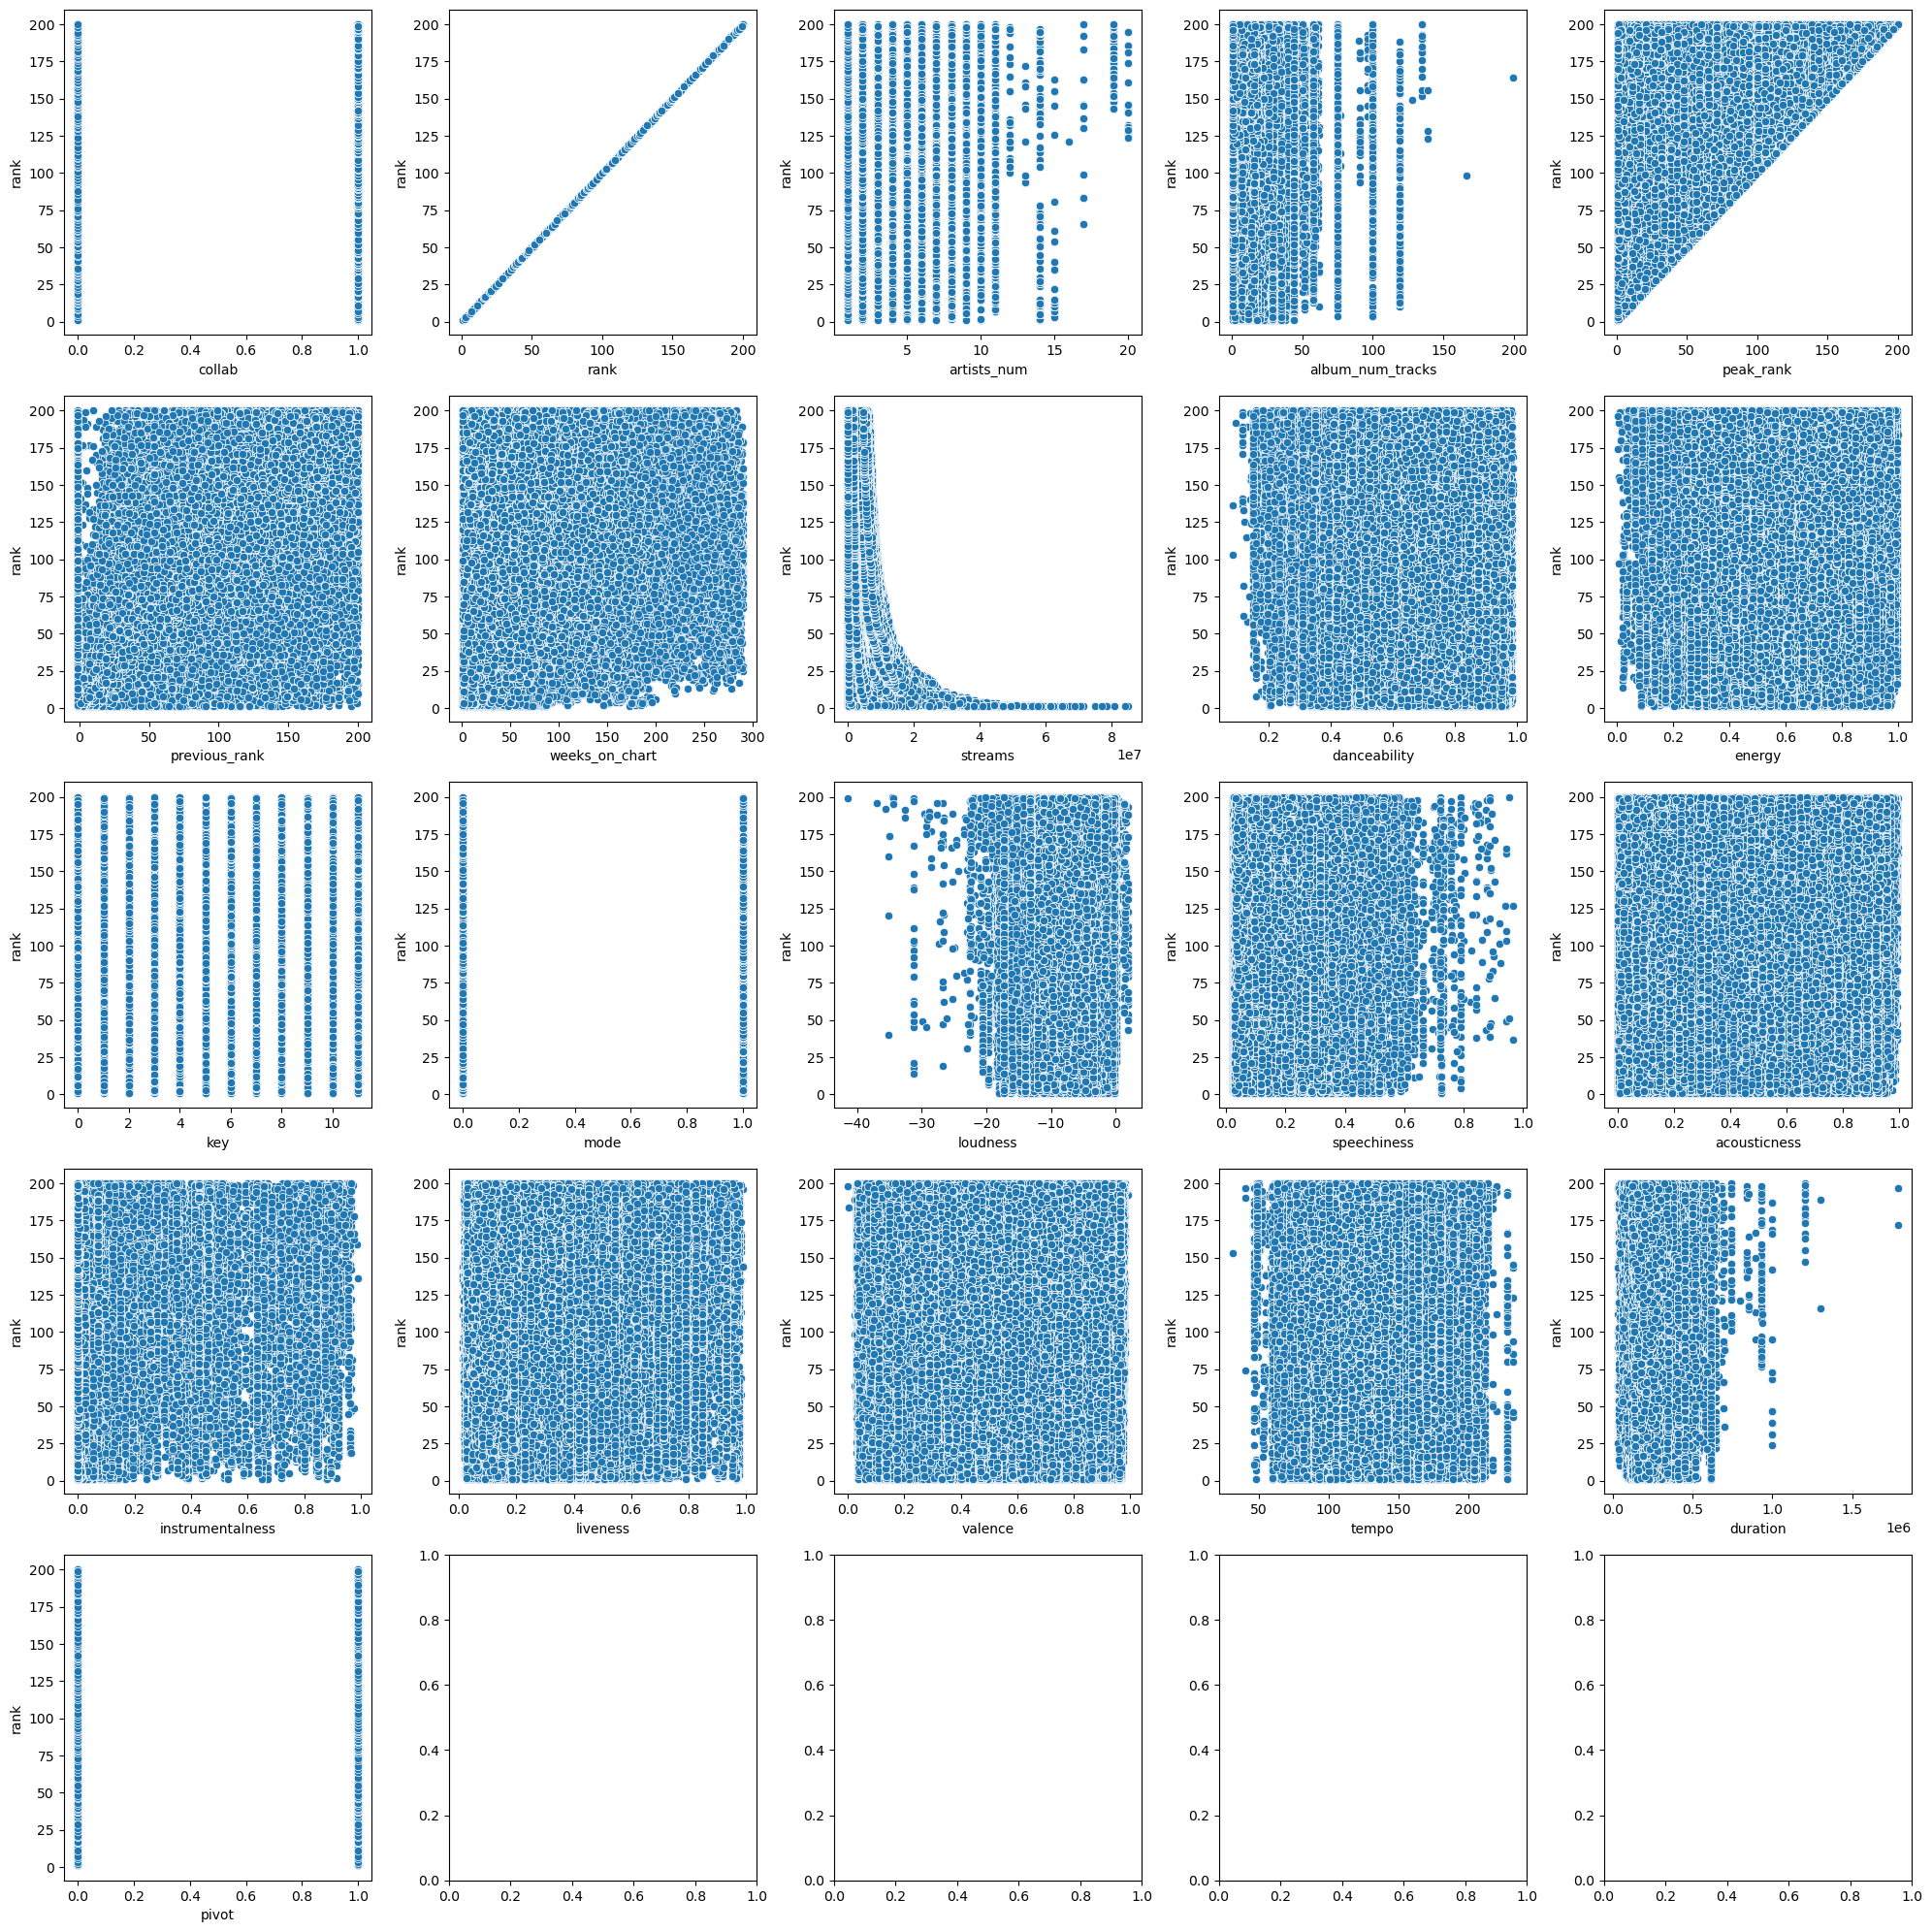

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes_flattened = axes.reshape(-1)
for i in range(len(num_df.columns)):
    ax = axes_flattened[i]
    sns.scatterplot(
        x=num_df.iloc[:, i],
        y='rank',
        data=num_df.dropna(),
        ax=ax,
    )
fig.tight_layout(pad=1.0)

/tmp/ipykernel_99137/1612872831.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method),


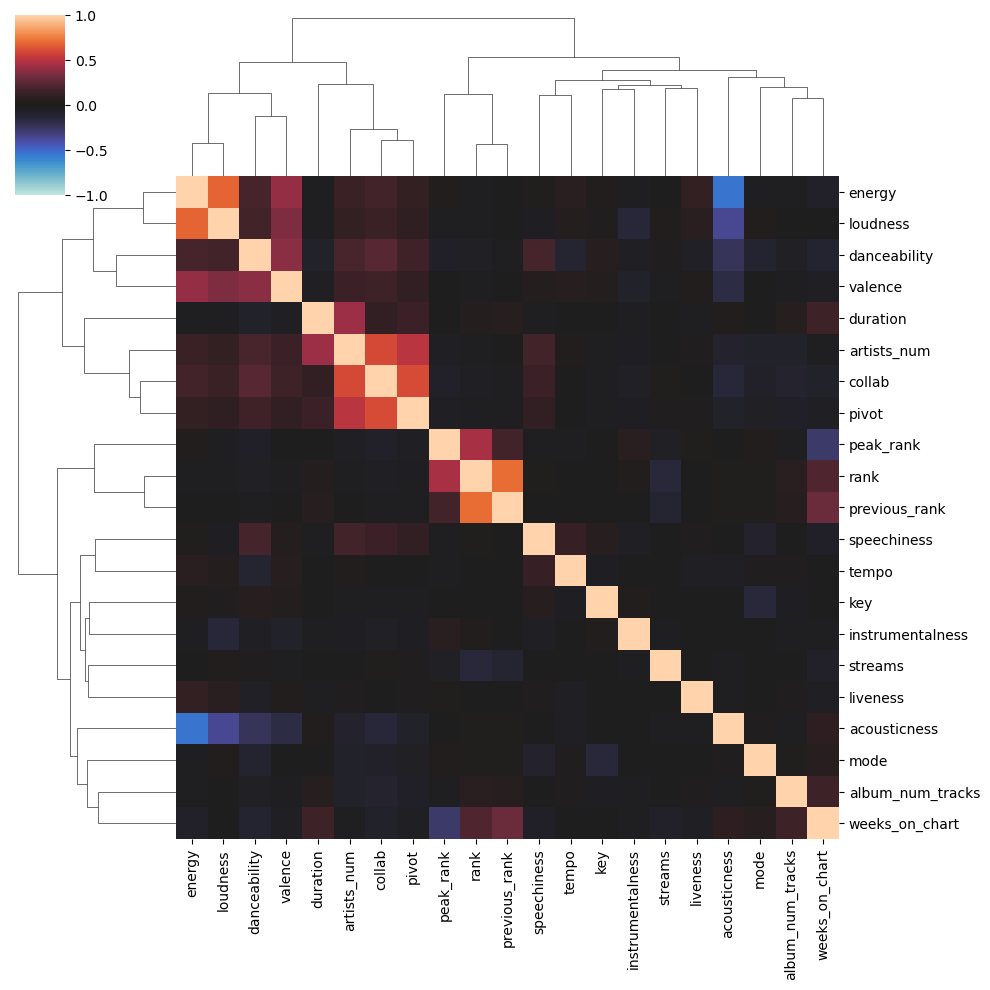

In [17]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df, annot=None)

In [18]:
df.drop(
    ['previous_rank','energy'],
    axis=1,
    inplace=True
)

In [19]:
nan_df = (df.isnull().mean() * 100).reset_index()
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
11,loudness,0.022093
14,instrumentalness,0.022093
18,duration,0.022093
17,tempo,0.022093
16,valence,0.022093
8,danceability,0.022093
9,key,0.022093
10,mode,0.022093
15,liveness,0.022093
12,speechiness,0.022093


In [20]:
intro_srt = "Number of columns with more than"
for percent in (0.1, 0.01):
    print(f"{intro_srt} {percent}% NANs: {(nan_df.percentage > percent).sum()}")

Number of columns with more than 0.1% NANs: 0
Number of columns with more than 0.01% NANs: 11


In [21]:
df = df.dropna()
df = df.reset_index(drop=True)
df.shape

(1787531, 23)

In [22]:
def get_almost_constant_columns(df, dropna=True):
    cols = []
    for i in df:
        if dropna:
            counts = df[i].dropna().value_counts()
        else:
            counts = df[i].value_counts()
        most_popular_value_count = counts.iloc[0]
        if (most_popular_value_count / len(df)) * 100 > 96:
            cols.append(i)
    return cols

In [23]:
cat_df = df.select_dtypes(include=['object'])
overfit_cat = get_almost_constant_columns(cat_df)
overfit_cat

[]

In [24]:
num_df = df.select_dtypes(exclude=['object'])
overfit_num = get_almost_constant_columns(num_df, dropna=True)
overfit_num

[]

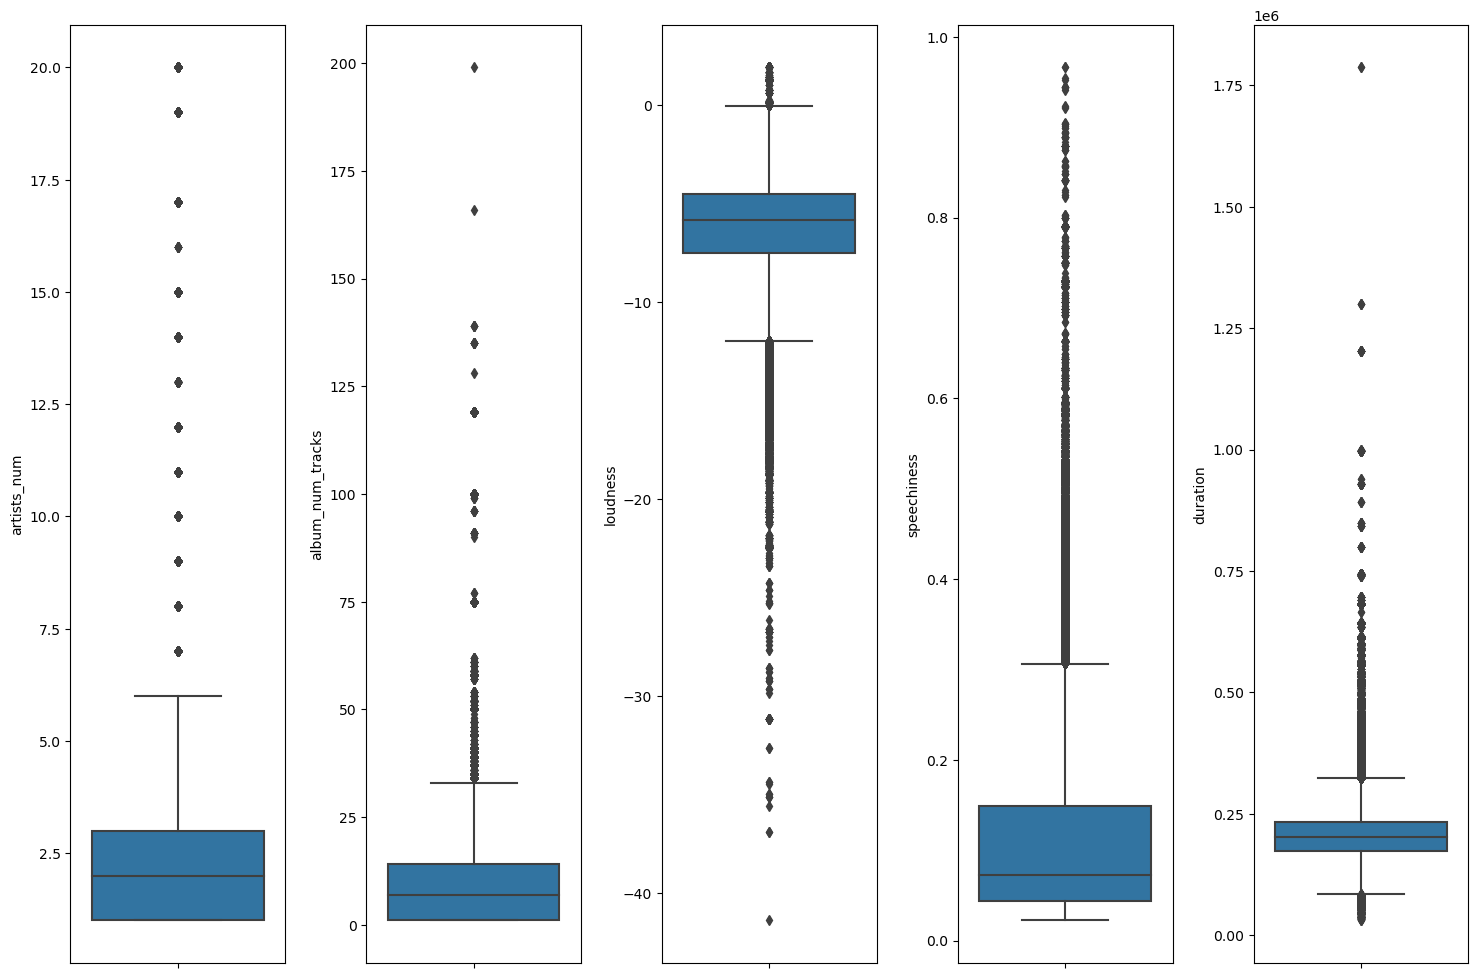

In [25]:
out_col = ['artists_num', 'album_num_tracks', 'loudness', 'speechiness', 'duration']

fig, axes = plt.subplots(1, 5, figsize=(15, 10))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=df[col], data=df, ax=ax)
fig.tight_layout(pad=1.5)

In [26]:
#for col, upper_bound in (
 #   ('album_num_tracks', 150),
  #  #('loudness', 100000),
  #  ('duration', 1.5)
#):
  #  df = df.drop(df[df[col] > upper_bound].index)

In [27]:
df.shape

(1787531, 23)

In [28]:
for column in cat_df:
    print(column, cat_df[column].nunique())

artist_genre 1874
country 74
region 10
language 40


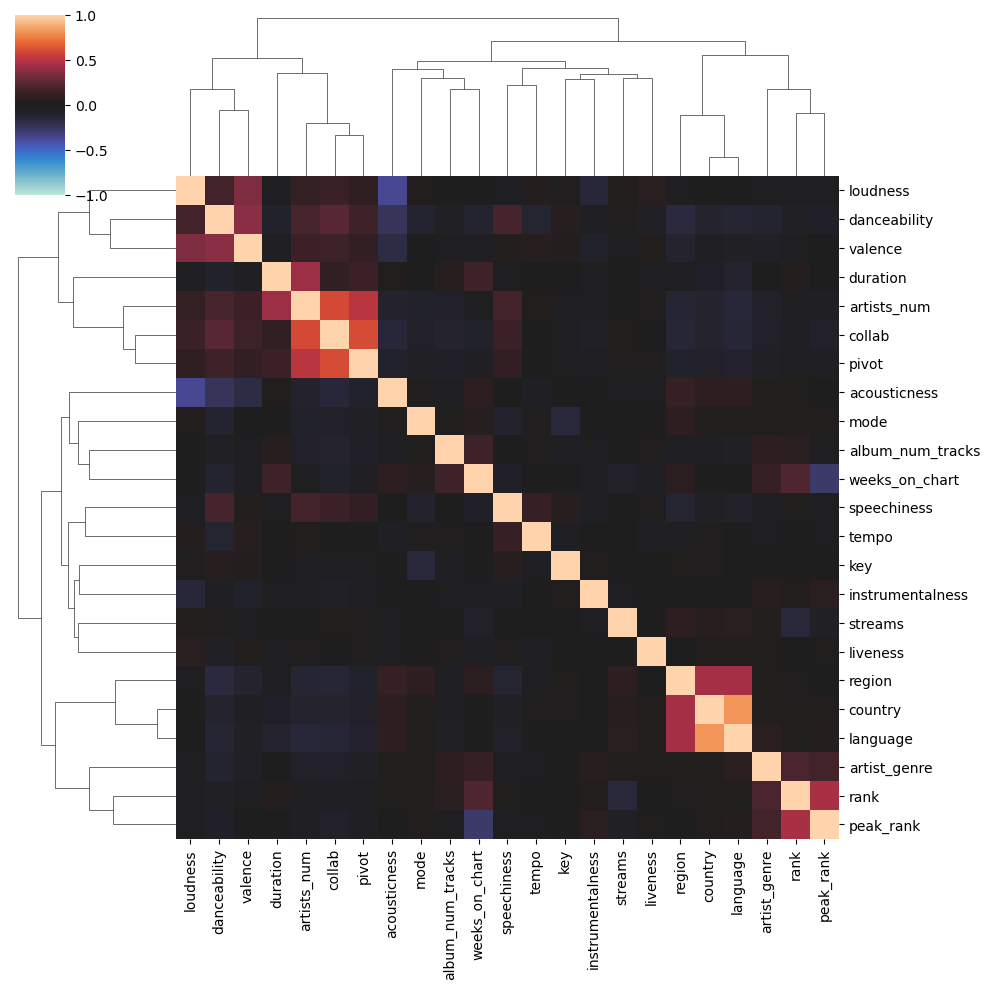

In [29]:
target_encoder = ce.TargetEncoder()
te_df_ = target_encoder.fit_transform(cat_df, df['rank'])
te_df_.head()
df_to_study_addiction_btw_region_and_country = pd.concat([num_df, te_df_], axis=1, join='inner')
corrplot(df_to_study_addiction_btw_region_and_country, annot=None)

In [30]:
cat_df.drop(
    ['language'],
    axis=1,
    inplace=True
)

In [31]:
target_encoder = ce.TargetEncoder()
te_df = target_encoder.fit_transform(cat_df['artist_genre'], df['rank'])
te_df.head()

,artist_genre
0,101.795297
1,125.986046
2,101.795297
3,83.306098
4,81.694801


In [32]:
ohe_df = pd.get_dummies(cat_df[['region', 'country']])
ohe_df.head()

,region_Africa,region_Asia,region_Caribbean,region_Central America,region_Europe,region_Global,region_Middle East,region_North America,region_Oceania,region_South America,...,country_Taiwan,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
num_df = df.select_dtypes(exclude=['object'])
df = pd.concat([num_df, ohe_df, te_df], axis=1, join='inner')
df

,collab,rank,artists_num,album_num_tracks,peak_rank,weeks_on_chart,streams,danceability,key,mode,...,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam,artist_genre
0,0,1,1.0,1.0,1,4,3003411,0.583,0.0,1.0,...,0,0,0,0,0,0,0,0,0,101.795297
1,0,2,1.0,1.0,2,2,2512175,0.654,5.0,1.0,...,0,0,0,0,0,0,0,0,0,125.986046
2,0,3,1.0,2.0,3,2,2408983,0.721,1.0,0.0,...,0,0,0,0,0,0,0,0,0,101.795297
3,0,5,1.0,1.0,5,8,2080139,0.870,10.0,0.0,...,0,0,0,0,0,0,0,0,0,83.306098
4,0,6,1.0,1.0,6,3,1923270,0.761,7.0,0.0,...,0,0,0,0,0,0,0,0,0,81.694801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787526,1,197,2.0,33.0,197,1,37591,0.743,4.0,1.0,...,0,0,0,0,0,0,0,0,1,97.683898
1787527,1,197,2.0,33.0,197,1,37591,0.743,4.0,1.0,...,0,0,0,0,0,0,0,0,1,111.794229
1787528,1,199,3.0,17.0,114,30,36817,0.795,1.0,1.0,...,0,0,0,0,0,0,0,0,1,95.282063
1787529,1,199,3.0,17.0,114,30,36817,0.795,1.0,1.0,...,0,0,0,0,0,0,0,0,1,97.683898


# Model training section

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [35]:
df.head()

,collab,rank,artists_num,album_num_tracks,peak_rank,weeks_on_chart,streams,danceability,key,mode,...,country_Thailand,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Vietnam,artist_genre
0,0,1,1.0,1.0,1,4,3003411,0.583,0.0,1.0,...,0,0,0,0,0,0,0,0,0,101.795297
1,0,2,1.0,1.0,2,2,2512175,0.654,5.0,1.0,...,0,0,0,0,0,0,0,0,0,125.986046
2,0,3,1.0,2.0,3,2,2408983,0.721,1.0,0.0,...,0,0,0,0,0,0,0,0,0,101.795297
3,0,5,1.0,1.0,5,8,2080139,0.870,10.0,0.0,...,0,0,0,0,0,0,0,0,0,83.306098
4,0,6,1.0,1.0,6,3,1923270,0.761,7.0,0.0,...,0,0,0,0,0,0,0,0,0,81.694801


Дерево решений

In [36]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [37]:
target = 'peak_rank'
features = list(df.columns)
features.remove(target)
features

['collab',
 'rank',
 'artists_num',
 'album_num_tracks',
 'weeks_on_chart',
 'streams',
 'danceability',
 'key',
 'mode',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration',
 'pivot',
 'region_Africa',
 'region_Asia',
 'region_Caribbean',
 'region_Central America',
 'region_Europe',
 'region_Global',
 'region_Middle East',
 'region_North America',
 'region_Oceania',
 'region_South America',
 'country_Argentina',
 'country_Australia',
 'country_Austria',
 'country_Belarus',
 'country_Belgium',
 'country_Bolivia',
 'country_Brazil',
 'country_Bulgaria',
 'country_Canada',
 'country_Chile',
 'country_Colombia',
 'country_Costa Rica',
 'country_Cyprus',
 'country_Czech Republic',
 'country_Denmark',
 'country_Dominican Republic',
 'country_Ecuador',
 'country_Egypt',
 'country_El Salvador',
 'country_Estonia',
 'country_Finland',
 'country_France',
 'country_Germany',
 'country_Global',
 'country_Greece',
 'country_Guatemala',


In [38]:
X = df[features]
y = df[[target]]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8, shuffle=True)
for leaf in range(200000, 250001, 10000):
    tree = DecisionTreeClassifier(max_depth=53, min_samples_leaf=1, max_leaf_nodes=leaf)
    tree.fit(X_train, y_train)
    print(f'leaf = {leaf}, acc = {tree.score(X_test, y_test)}')


leaf = 200000, acc = 0.7996710553919224
leaf = 210000, acc = 0.8045604701446405
leaf = 220000, acc = 0.8079422221103363
leaf = 230000, acc = 0.8109659391284646
leaf = 240000, acc = 0.8113407569641993
leaf = 250000, acc = 0.8107785302105973


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8, shuffle=True)
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

In [41]:
tree.predict_proba(X_test)[:, 1]

array([0.0943247 , 0.05081967, 0.02654867, ..., 0.00724966, 0.13311577,
       0.00098923])

In [42]:
tree.score(X_test, y_test)

0.17735876500320275

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree, ax=ax)

KeyboardInterrupt: 

KNN

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
target = 'peak_rank'
features = list(df.columns)
features.remove(target)
features

In [ ]:
X = df[features]
y = df[[target]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8, shuffle=True)

In [ ]:
K_NEIGHBORS = 5
knn_wdbc_sklearn = KNeighborsClassifier(
    n_neighbors=K_NEIGHBORS, metric="euclidean", algorithm="brute", weights="uniform"
)
knn_wdbc_sklearn.fit(X=X, y=y.values.reshape(-1))
y_wdbc_pred_sklearn = knn_wdbc_sklearn.predict(X=X)
print("kNN sklearn: ", accuracy_score(y_true=y, y_pred=y_wdbc_pred_sklearn))